# Content

* 1. Focusing on Aggregate CashIn and CashOut
    * 1.1 Outliers: Removing 0s
    * 1.2 Switching to DateimeIndex
    * 1.3 Outliers: Revisited
    * 1.4 Shifting and Correlation
* 2. Focusing on Individual ATMs
    * 2.1 Correlation Analysis
* 3. Predictions with the Aggregate Demand

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("DATA_sample_atm.csv")

In [5]:
df.tail()

,AtmId,HistoryDate,CashIn,CashOut
2175132,126020,2020-04-29,2470.0,2950.0
2175133,126020,2020-04-30,4265.0,7580.0
2175134,126020,2020-05-01,650.0,0.0
2175135,126020,2020-05-02,130.0,0.0
2175136,126020,2020-05-03,150.0,1500.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2175137 entries, 0 to 2175136
Data columns (total 4 columns):
 #   Column       Dtype  
---  ------       -----  
 0   AtmId        int64  
 1   HistoryDate  object 
 2   CashIn       float64
 3   CashOut      float64
dtypes: float64(2), int64(1), object(1)
memory usage: 66.4+ MB


# 1. Focusing on Aggregate CashIn and CashOut

In [7]:
means = df.groupby("HistoryDate").mean()[['CashIn','CashOut']]

In [8]:
means.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1618 entries, 2016-01-01 to 2020-06-05
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CashIn   1618 non-null   float64
 1   CashOut  1618 non-null   float64
dtypes: float64(2)
memory usage: 37.9+ KB


In [9]:
means.head()

,CashIn,CashOut
HistoryDate,,
2016-01-01,22632.234742,23631.737089
2016-01-02,27636.545784,23876.908432
2016-01-03,23769.291480,16629.013453
2016-01-04,89314.589455,39836.343993
2016-01-05,52711.622088,52577.523727


In [10]:
means.describe()

,CashIn,CashOut
count,1618.000000,1618.000000
mean,47680.644573,40954.685820
std,17880.294810,16753.696413
min,0.000000,0.000000
25%,36615.979504,30940.092949
50%,49189.097252,40482.860490
75%,58848.846459,50392.971723
max,114298.284416,147888.927069


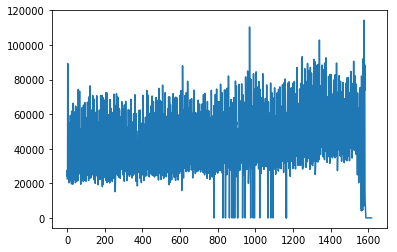

In [11]:
plt.plot(means['CashIn'].values)
plt.show()

### Line Plot with plotly

In [12]:
import plotly.express as px

draw_df = pd.DataFrame(means.stack()).reset_index()
draw_df.columns = ['HistoryDate', "Type", "Amount"]

fig = px.line(draw_df, x="HistoryDate", y="Amount", color='Type')
fig.show()

We have outliers:
- Some values are 0.
- There are large spikes in some places.
- There is a plato at the end

I will begin with removing the 0s.

## 1.1 Removing Plato at the End

In [13]:
means.tail()

,CashIn,CashOut
HistoryDate,,
2020-06-01,0.0,0.0
2020-06-02,0.0,0.0
2020-06-03,0.0,0.0
2020-06-04,0.0,0.0
2020-06-05,0.0,0.0


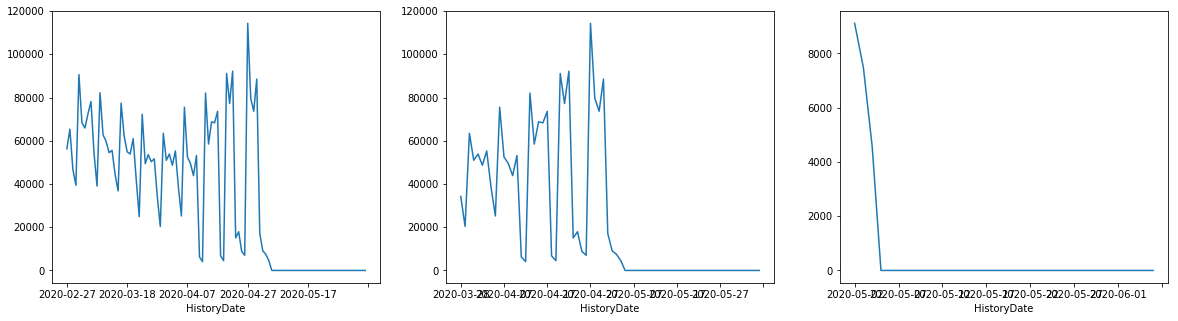

In [14]:
fig, axes = plt.subplots(1,3, figsize=(20, 5))

for ax, begin in zip(axes, [-100, -70, -35]):
    means['CashIn'][begin:].plot(ax = ax)

In [15]:
means = means[:-35]

## 1.2 Outliers: Removing 0s

Let's see the distribution using bin graphs:

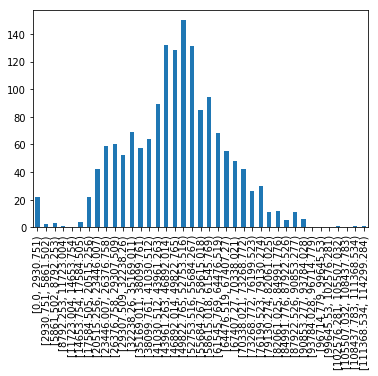

In [16]:
DRAW_BIN_WITH = 'CashIn'
N_BINS = 40

begin = means.describe().loc['min'][DRAW_BIN_WITH]
to = means.describe().loc['max'][DRAW_BIN_WITH]
bins = np.linspace(start = begin, stop = to + 1, num = N_BINS)

pd.cut(means[DRAW_BIN_WITH], bins, right=False).value_counts(sort=False).plot.bar()

In [17]:
(means == 0.0).value_counts()

CashIn  CashOut
False   False      1561
True    True         22
dtype: int64

54 rows have 0 in CashIn column

In [18]:
# input:    dataframe['CashIn', 'CashOut']
# do:       remove outliers and interpolate. inplace=True by default. Maybe add an option
def clean_data(df, freq='D', drop_zeros=True):
    # switch to datetimeIndex
    df.index = pd.to_datetime(df.index)

    # clean outliers
    # This may not be the best course of action when we are looking at a single ATM
    if drop_zeros:
        df[df['CashIn'] == 0] = np.NaN

    # upsample
    df = df.resample('D').asfreq()

    # interpolate (Maybe add better methods later)
    df = df.interpolate()

    return df

In [19]:
means = clean_data(means)

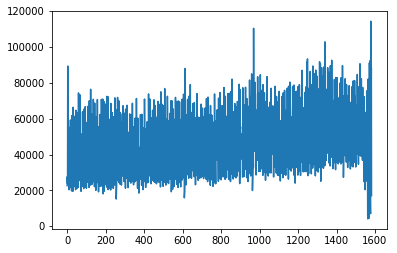

In [20]:
plt.plot(means['CashIn'].values)
plt.show()

Looking at the numbers and standard diviation after dropping null values

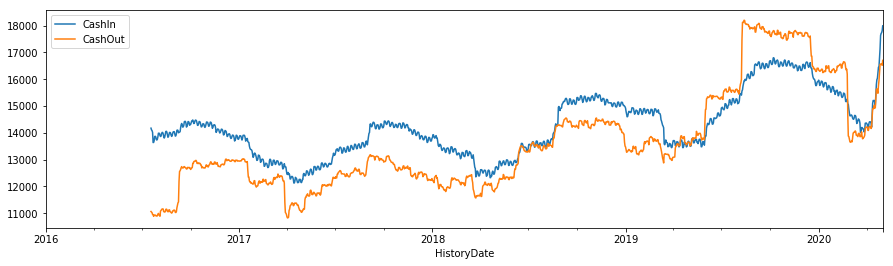

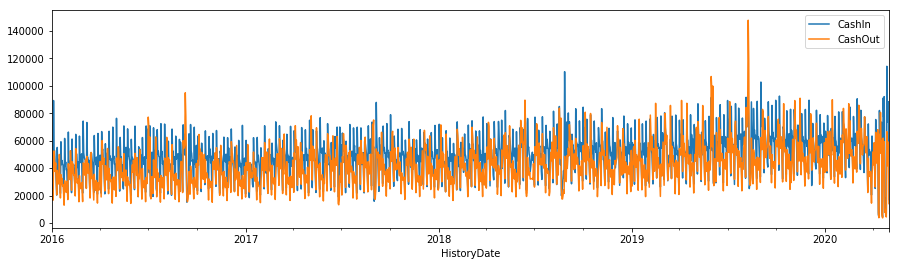

In [21]:
means.rolling(200).std().plot(figsize=(15, 4))
means.plot(figsize=(15, 4))

Here are the bins after removing the 0s (Using pandas alternative to manually creating the bins):

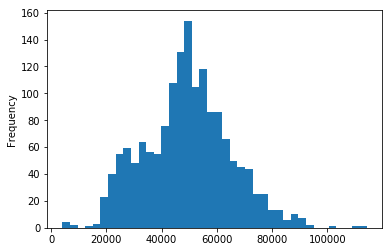

In [22]:
means[DRAW_BIN_WITH].plot.hist(bins = N_BINS)

### Bar Plot with plotly

In [23]:
# reference: https://plotly.com/python/bar-charts/

import plotly.graph_objects as go

N_BINS = 20

begin = means.describe().loc['min'].min()
to = means.describe().loc['max'].max()

bins = pd.Series(np.linspace(start = begin-1, stop = to + 1, num = N_BINS))
get_bin_values = lambda x: pd.cut(means[x], bins, right=False).value_counts(sort=False) 

fig = go.Figure(data=[
    go.Bar(name='CashIn', x=bins, y=get_bin_values('CashIn')),
    go.Bar(name='CashOut', x=bins, y=get_bin_values('CashOut'))
])

fig.update_layout(barmode='group')
fig.show()

## 1.3 Outliers: Investigating Spikes

There are some spikes in the data. Observe the CashOut spike in 2019:

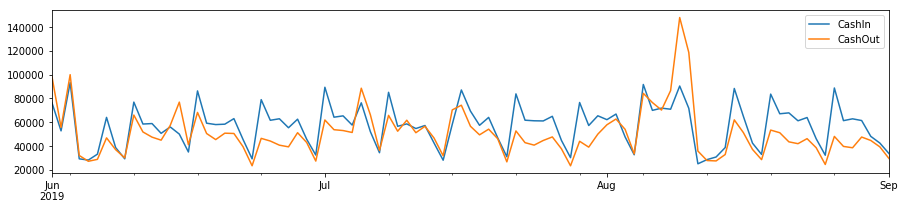

In [24]:
quarter_range = pd.date_range(start='2019-06', end='2019-09')
means.loc[quarter_range].plot(figsize = (15,3))

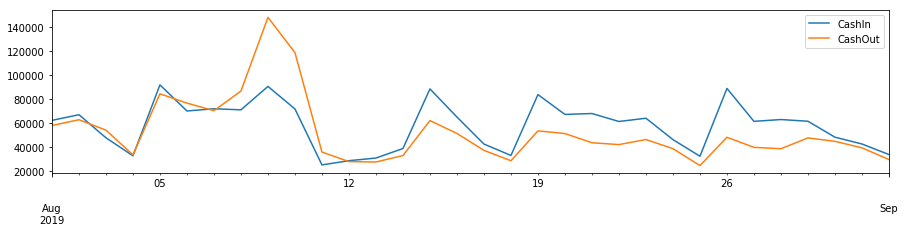

In [25]:
month_range = pd.date_range(start='2019-8', end='2019-09')
means.loc[month_range].plot(figsize = (15,3))

In [26]:
month_range = pd.date_range(start='2019-8-5', end='2019-08-12')
means.loc[month_range]

,CashIn,CashOut
2019-08-05,91676.822331,84241.242978
2019-08-06,69950.590302,76510.442727
2019-08-07,71816.066667,70209.150877
2019-08-08,70916.528752,86513.772791
2019-08-09,90392.279102,147888.927069
2019-08-10,71668.636045,118548.302945
2019-08-11,25088.373072,35773.723703
2019-08-12,28588.180224,27834.467041


Jump in outflow happens at 9th of August, 2019. See the news in the links below (There is a paywall in Bloomberg, so it's a good idea to click the second link first):
- [Investors Scramble for Liras as Turkish Swap Rates Touch 1,000%](https://www.bloomberg.com/news/articles/2019-03-27/foreign-investors-are-trapped-in-turkey-days-before-elections), March 27th
- [Turkey Central Bank Removes Chief Economist, Key Officials](https://www.bloomberg.com/news/articles/2019-08-08/turkey-central-bank-removes-chief-economist-other-officials-jz34v7c6), August 9th. Hakan Kara is removed from TCMB
- [Foreigners Flee Turkish Stocks at Fastest Pace Since March 2019](https://www.bloomberg.com/news/articles/2020-08-13/foreigners-flee-turkish-stocks-at-fastest-pace-since-march-2019), August 13th

## 1.4 Shifting and Correlation

In [27]:
means['CashIn'].shift(2)

HistoryDate
2016-01-01              NaN
2016-01-02              NaN
2016-01-03     22632.234742
2016-01-04     27636.545784
2016-01-05     23769.291480
                  ...      
2020-04-27      8818.158630
2020-04-28      7012.547170
2020-04-29    114298.284416
2020-04-30     79616.571029
2020-05-01     73649.901961
Freq: D, Name: CashIn, Length: 1583, dtype: float64

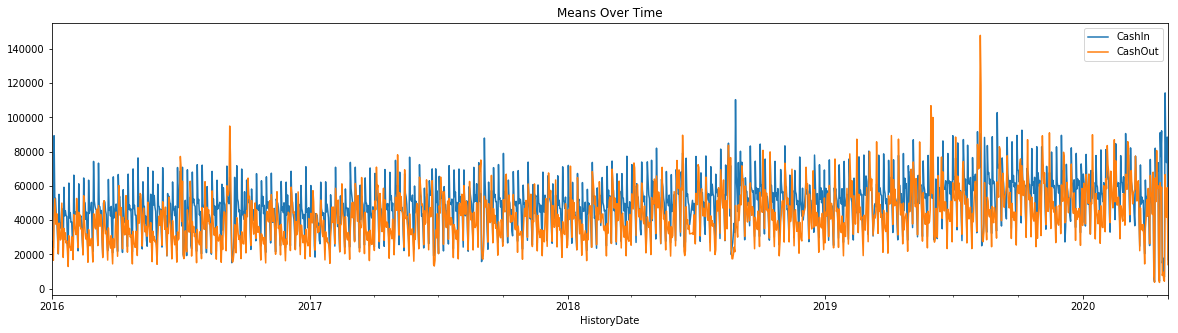

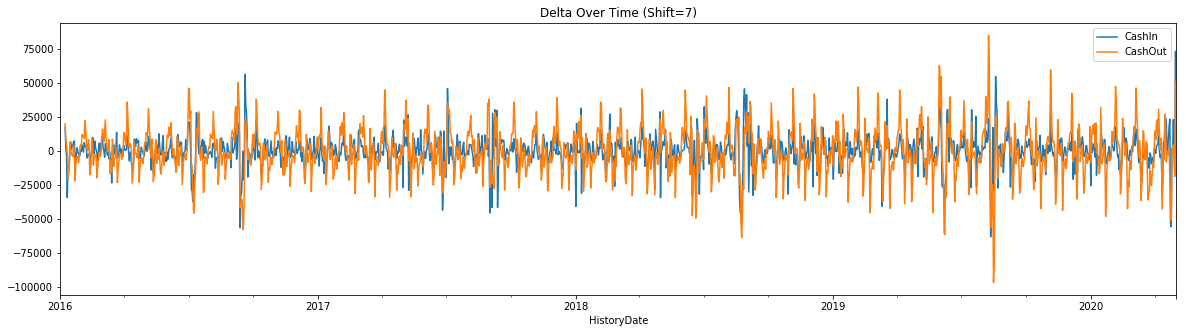

In [28]:
DELTA_OFFSET = 7
deltas = means - means.shift(DELTA_OFFSET)
means.plot(title="Means Over Time", figsize=(20,5))
deltas.plot(title="Delta Over Time (Shift=%d)" % DELTA_OFFSET, figsize=(20,5))


In [29]:
MAX_SHIFT = 28
shift_stds = pd.DataFrame(columns = ['CashIn_std', 'CashOut_std'])
for shift_by in range(1, MAX_SHIFT):
    deltas = means - means.shift(shift_by)
    shift_stds.loc[shift_by, 'CashIn_std'] = deltas['CashIn'].std()
    shift_stds.loc[shift_by, 'CashOut_std'] = deltas['CashOut'].std()
shift_stds.index = "shift_by_" + shift_stds.index.astype(str)

print()
print(shift_stds.sort_values(by = 'CashOut_std')[:5])
print()
print(shift_stds.sort_values(by = 'CashIn_std')[:5])


               CashIn_std   CashOut_std
shift_by_1    20805.99368  15552.932501
shift_by_7   11357.974352   17121.56576
shift_by_21  10792.753942  17254.544725
shift_by_3   21685.305092  17951.519943
shift_by_14  10651.839861  18180.742345

               CashIn_std   CashOut_std
shift_by_14  10651.839861  18180.742345
shift_by_21  10792.753942  17254.544725
shift_by_7   11357.974352   17121.56576
shift_by_1    20805.99368  15552.932501
shift_by_17  20962.430259  20724.965383


# 2. Focusing on Individual ATMs

In [30]:
"Number of unique ATMs: %d" % len(df['AtmId'].unique())

'Number of unique ATMs: 1650'

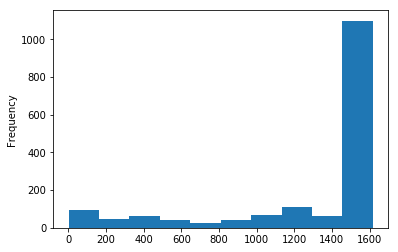

In [31]:
df['AtmId'].value_counts().plot.hist()
plt.show()

In [32]:
df['AtmId'].value_counts()[:3]

26637    1618
27687    1618
27663    1618
Name: AtmId, dtype: int64

In [33]:
# input:    all the atm data, an atm ID
# do:       get the data of the given atm and clean it
# return:   dataframe['CashIn', 'CashOut'] for the given ATM ID
def get_atm(df, atm_id):
    
    atm_df = df[df['AtmId'] == atm_id].copy()
    atm_df.drop(columns = 'AtmId', inplace = True)
    atm_df.set_index('HistoryDate', inplace = True)
    atm_df.index = pd.to_datetime(atm_df.index)
    
    return atm_df

In [34]:
atm_df = clean_data(get_atm(df, 26637))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001B22A1216C8>,
      dtype=object)

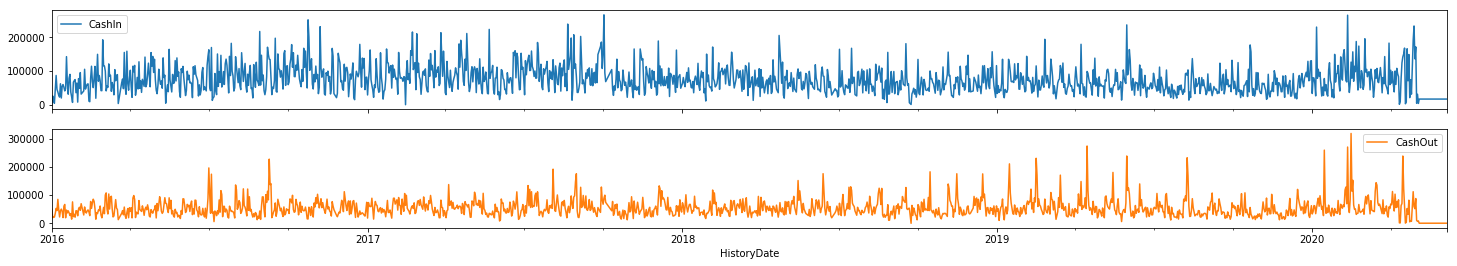

In [35]:
atm_df[['CashIn', 'CashOut']].plot(figsize=(25,4), subplots = True)

## 2.1 Correlation Analysis

In [36]:
def get_windows(series, size, prefix = "", drop_t = False):
    frame = pd.DataFrame(series.copy())
    frame.columns = ['t']

    for shift_by in range(1, size+1):
        frame[prefix + "t-" + str(shift_by)] = frame['t'].shift(shift_by)

    frame.dropna(inplace = True)

    if drop_t:
        frame.drop(columns=['t'], inplace=True)

    return frame

In [37]:
atm_cashin = get_windows(means['CashIn'], 21)
corrs = atm_cashin.corr()

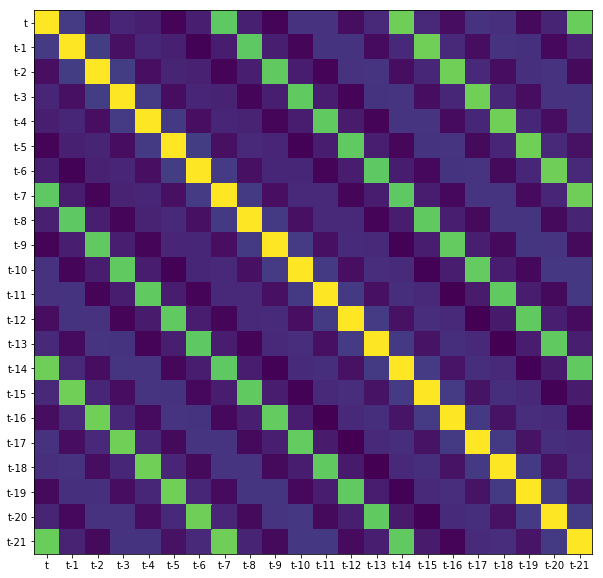

In [38]:
# invert y axis, this way the image will resemble a proper matrix with 1s in the correct diagonal
# https://stackoverflow.com/questions/2051744/reverse-y-axis-in-pyplot
plt.figure(figsize=(10,10))
plt.gca().invert_yaxis()

plt.pcolor(corrs)
plt.yticks(np.arange(0.5, len(corrs.index), 1), corrs.index)
plt.xticks(np.arange(0.5, len(corrs.columns), 1), corrs.columns)
plt.show()

In [40]:
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#plot_acf(means['CashOut'],lags=30,title="CashOut correlation")
#plt.show()

I am unable to run the code above becuase of an error. I will try handling it later.

## 3. Feature Generation

Plan: for each day `t`, generate a feature set with:
* [28] Last 14 days of CashIn and CashOut `(t-1)` to `(t-14)`
* [1] Which day of the week? 0 is monday
* [1] Proximity of payday: Offset of the closest payday
* [1] Proximity of payday (absolute): Distance to the closest payday
* [2] Weekday/weekend (one-hot)
* [2] CashIn/CashOut averages of the last week
* [2] CashIn/CashOut averages of the last month

In [41]:
from datetime import datetime



In [147]:
# input:    dataframe['CashIn', 'CashOut'], date
# do:       generate a feature set for the given date
# return:   return the feature set
def get_feature_sets(df):
    will_merge = [df]

    # Last 14 days of CashIn
    cashIn_windows = get_windows(df['CashIn'], 14, "CashIn_", drop_t=True)
    # Last 14 days of CashOut
    cashOut_windows = get_windows(df['CashOut'], 14, "CashOut_", drop_t=True)

    # Weekday as integer
    first_date = df.index[0]
    first_date_weekday = int(first_date.strftime('%w'))
    a1 = np.arange(first_date_weekday,7)
    a2 = np.arange(first_date_weekday)
    sequence = np.roll(np.concatenate([a1, a2]), 1)

    weekdays = pd.concat([pd.Series(sequence)] * (int(len(df)/7)+1))[:len(df)]
    weekdays.name = "Day_Index"
    weekdays.index = df.index
    will_merge.append(weekdays)

    week_days_one_hot = pd.get_dummies(weekdays, prefix = "Day")    
    will_merge.append(week_days_one_hot)

    # Weekday/weekend (one-hot)
    is_weekday = weekdays.copy()
    is_weekday[is_weekday < 5] = 1
    is_weekday[is_weekday > 4] = 0
    is_weekday.name = "Is_Weekday"
    is_weekend = 1 - is_weekday
    is_weekend.name = "Is_Weekend"

    will_merge.append(is_weekday)
    will_merge.append(is_weekend)

    # CashIn/CashOut averages of the last week/month
    get_average_of_last = [7, 30]
    for n_days in get_average_of_last:
        cashIn_average = cashIn_windows[cashIn_windows.columns[:n_days]].mean(axis=1)
        cashIn_average.name = "CashIn_average_" + str(n_days)
        cashOut_average = cashOut_windows[cashOut_windows.columns[:n_days]].mean(axis=1)
        cashOut_average.name = "CashOut_average_" + str(n_days)

        will_merge.append(cashIn_average)
        will_merge.append(cashOut_average)
    
    # all features are created and frames are added to will_merge except for cashIn_windows and cashOut_windows

    will_merge.extend([cashIn_windows, cashOut_windows])

    result = pd.concat(will_merge, axis=1)
    result.dropna(inplace=True)
    
    return result

In [148]:
feature_set = get_feature_sets(means)
feature_set.head(3)

,CashIn,CashOut,Day_Index,Day_0,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,...,CashOut_t-5,CashOut_t-6,CashOut_t-7,CashOut_t-8,CashOut_t-9,CashOut_t-10,CashOut_t-11,CashOut_t-12,CashOut_t-13,CashOut_t-14
HistoryDate,,,,,,,,,,,,,,,,,,,,,
2016-01-15,46815.029991,49997.206512,4,0,0,0,0,1,0,0,...,20521.749571,33242.343348,43740.910653,37534.725086,45121.282272,52577.523727,39836.343993,16629.013453,23876.908432,23631.737089
2016-01-16,36110.831191,33120.916881,5,0,0,0,0,0,1,0,...,38354.708405,20521.749571,33242.343348,43740.910653,37534.725086,45121.282272,52577.523727,39836.343993,16629.013453,23876.908432
2016-01-17,21564.104542,18269.168809,6,0,0,0,0,0,0,1,...,32799.991431,38354.708405,20521.749571,33242.343348,43740.910653,37534.725086,45121.282272,52577.523727,39836.343993,16629.013453


### Correlation between the generated features:

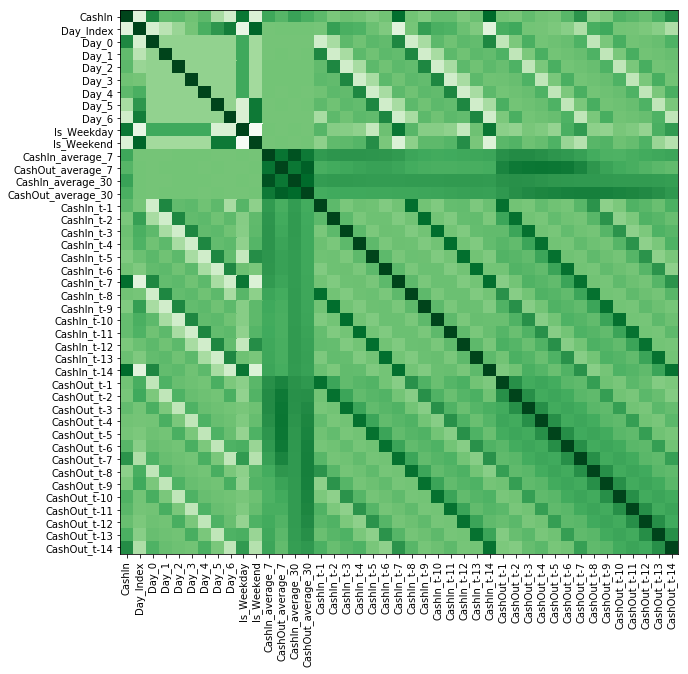

In [149]:
CORRELATION_WITH = "CashIn"

if CORRELATION_WITH == "CashOut":
    corrs = feature_set[feature_set.drop(columns='CashIn').columns].corr()
else:
    corrs = feature_set[feature_set.drop(columns='CashOut').columns].corr()

plt.figure(figsize=(10,10))
plt.gca().invert_yaxis()

# https://matplotlib.org/stable/tutorials/colors/colormaps.html
plt.pcolor(corrs, cmap = "Greens")
plt.yticks(np.arange(0.5, len(corrs.index), 1), corrs.index)
plt.xticks(np.arange(0.5, len(corrs.columns), 1), corrs.columns, rotation = 'vertical')
plt.show()

## 4. Predictions with the Aggregate Demand

In [ ]:
MAX_SHIFT = 14
PREDICT_FEATURE = 'CashOut'
means_shifted = pd.DataFrame(means_interpolated[PREDICT_FEATURE].copy(), columns=[PREDICT_FEATURE])
for shift_by in range(1, MAX_SHIFT+1):
    means_shifted['shift_by_' + str(shift_by)] = means_shifted[PREDICT_FEATURE].shift(shift_by)
means_shifted.dropna(inplace=True)
means_shifted

,CashOut,shift_by_1,shift_by_2,shift_by_3,shift_by_4,shift_by_5,shift_by_6,shift_by_7,shift_by_8,shift_by_9,shift_by_10,shift_by_11,shift_by_12,shift_by_13,shift_by_14
HistoryDate,,,,,,,,,,,,,,,
2016-01-15,49997.206512,29305.484147,28441.979434,32799.991431,38354.708405,20521.749571,33242.343348,43740.910653,37534.725086,45121.282272,52577.523727,39836.343993,16629.013453,23876.908432,23631.737089
2016-01-16,33120.916881,49997.206512,29305.484147,28441.979434,32799.991431,38354.708405,20521.749571,33242.343348,43740.910653,37534.725086,45121.282272,52577.523727,39836.343993,16629.013453,23876.908432
2016-01-17,18269.168809,33120.916881,49997.206512,29305.484147,28441.979434,32799.991431,38354.708405,20521.749571,33242.343348,43740.910653,37534.725086,45121.282272,52577.523727,39836.343993,16629.013453
2016-01-18,35241.131105,18269.168809,33120.916881,49997.206512,29305.484147,28441.979434,32799.991431,38354.708405,20521.749571,33242.343348,43740.910653,37534.725086,45121.282272,52577.523727,39836.343993
2016-01-19,28751.970865,35241.131105,18269.168809,33120.916881,49997.206512,29305.484147,28441.979434,32799.991431,38354.708405,20521.749571,33242.343348,43740.910653,37534.725086,45121.282272,52577.523727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-30,59007.215190,41672.254902,44727.494752,66618.791055,4382.606569,5443.039832,9775.904962,7763.004892,59295.893855,52440.935754,61922.145353,3690.817610,5705.897973,60138.385744,58536.675978
2020-05-01,14122.028777,59007.215190,41672.254902,44727.494752,66618.791055,4382.606569,5443.039832,9775.904962,7763.004892,59295.893855,52440.935754,61922.145353,3690.817610,5705.897973,60138.385744
2020-05-02,7209.123328,14122.028777,59007.215190,41672.254902,44727.494752,66618.791055,4382.606569,5443.039832,9775.904962,7763.004892,59295.893855,52440.935754,61922.145353,3690.817610,5705.897973


In [ ]:
def loss(y_predicted, y_actual):
    return ((y_predicted - y_actual) ** 2).mean()

In [ ]:
shift_losses = pd.DataFrame(dtype='float64', columns = ["Losses"])
for i, column in enumerate(means_shifted.columns[1:]):
    l = loss(means_shifted[PREDICT_FEATURE], means_shifted[column])
    shift_losses.loc[column, "Losses"] = l
shift_losses.sort_values(by = "Losses")

,Losses
shift_by_1,2.423323e+08
shift_by_7,2.955050e+08
shift_by_3,3.246914e+08
shift_by_14,3.319230e+08
shift_by_2,3.412174e+08
shift_by_4,3.486307e+08
shift_by_10,3.955361e+08
shift_by_5,3.962516e+08
shift_by_6,4.077076e+08
shift_by_11,4.250098e+08


These loss values are our base scores. We will compare these with the scores we get from models.

In [ ]:
X = means_shifted.drop(columns=PREDICT_FEATURE)
y = means_shifted[PREDICT_FEATURE]

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

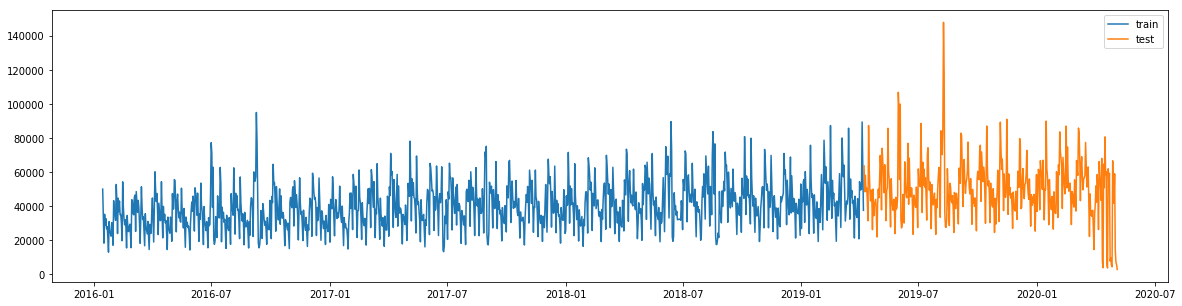

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(y_train, label="train")
plt.plot(y_test, label="test")
plt.legend()
plt.show()